## Ames Housing Project- Final Model 

### Problem Statement
I was just hired by a home appraisal company in Iowa as their very first data scientist.  After years of appraising homes by hand, they want a faster more effective and accurate system.  My job is too create a model that can take in the data they collect out in the field and return the true/fair market value of a house. Sucess will be evaluated on the RMSE score. 

Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

%matplotlib inline

Read in datasets

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

Rename columns

In [3]:
def rename_cols(df):
     df.rename(index=str, columns={
    'PID': 'parcel_id',
    'MS SubClass' : 'ms_subclass',
    'MS Zoning': 'zoning', 
    'Lot Frontage': 'lot_frontage',
    'Lot Area': 'lot_sq_ft',
    'Street': 'paved_street', 
    'Alley': 'alley', 
    'Lot Shape': 'lot_shape', 
    'Land Contour': 'flatness', 
    'Utilities': 'utilities',       
    'Lot Config': 'lot_config', 
    'Land Slope': 'land_slope', 
    'Neighborhood': 'neighborhood', 
    'Condition 1': 'proximity_1',
    'Condition 2': 'proximity_2', 
    'Bldg Type': 'building_type', 
    'House Style': 'style', 
    'Overall Qual': 'quality_rating',
    'Overall Cond': 'condition_rating', 
    'Year Built': 'year_built', 
    'Year Remod/Add': 'year_renovation', 
    'Roof Style': 'roof_style',
    'Roof Matl': 'roof_material', 
    'Exterior 1st': 'exterior_1', 
    'Exterior 2nd': 'exterior_2', 
    'Mas Vnr Type': 'masonry_type',
    'Mas Vnr Area': 'masonry_area', 
    'Exter Qual': 'exterior_quality', 
    'Exter Cond': 'exterior_condition', 
    'Foundation': 'foundation_type', 
    'Bsmt Qual': 'basement_height',
    'Bsmt Cond': 'basement_condition', 
    'Bsmt Exposure': 'basement_exposure', 
    'BsmtFin Type 1': 'basement_finished_condition', 
    'BsmtFin SF 1': 'basement_fin_sqft',
    'BsmtFin Type 2': 'basement_2_condition', 
    'BsmtFin SF 2': 'basement_2_sqft', 
    'Bsmt Unf SF': 'unfinished_basement_sqft', 
    'Total Bsmt SF': 'total_basement_sqft',
    'Heating': 'heating_type', 
    'Heating QC': 'heating_quality', 
    'Central Air': 'has_central_air', 
    'Electrical': 'electrical', 
    '1st Flr SF': 'first_fl_sqft',
    '2nd Flr SF': 'second_fl_sqft', 
    'Low Qual Fin SF': 'low_quality_sqft', 
    'Gr Liv Area': 'living_area_sqft', 
    'Bsmt Full Bath': 'basement_full_bath',
    'Bsmt Half Bath': 'basement_half_bath', 
    'Full Bath': 'full_bath', 
    'Half Bath': 'half_bath', 
    'Bedroom AbvGr': 'bedrooms',
    'Kitchen AbvGr': 'kitchens', 
    'Kitchen Qual': 'kitchen_quality', 
    'TotRms AbvGrd': 'total_rooms(non-bath_or_basement)', 
    'Functional': 'functionality',
    'Fireplaces': 'fireplaces', 
    'Fireplace Qu': 'fireplace_quality', 
    'Garage Type': 'garage_type', 
    'Garage Yr Blt': 'garage_year',
    'Garage Finish': 'garage_finish', 
    'Garage Cars': 'garage_size', 
    'Garage Area': 'garage_sqft', 
    'Garage Qual': 'garage_quality',
    'Garage Cond': 'garage_condition', 
    'Paved Drive': 'has_paved_driveway', 
    'Wood Deck SF': 'deck_sqft', 
    'Open Porch SF': 'open_porch_sqft',
    'Enclosed Porch': 'enclosed_porch_sqft', 
    '3Ssn Porch': 'seasonal_porch_sqft', 
    'Screen Porch': 'screen_porch_sqft', 
    'Pool Area': 'pool_size', 
    'Pool QC': 'pool_quality',
    'Fence': 'fence_quality', 
    'Misc Feature': 'misc_feature',
    'Misc Val': 'misc_value',
    'Mo Sold': 'month_sold', 
    'Yr Sold': 'year_sold', 
    'Sale Type': 'sale_type', 

    
}, inplace=True)
        

In [4]:
rename_cols(train)

Fill in nulls 

In [5]:
for col in train:
    if type(train[col])== 'int64' or 'float64':
        train[col] = train[col].fillna(value=0)
    else:
        train[col] = train[col].fillna(value='None')
        

In [6]:
train.isnull().sum().sum()

0

EDA: column combination, dropping and feature engineering

In [7]:
def EDA(df):
    df['baths'] = df['basement_full_bath'] + df['full_bath'] + (df['basement_half_bath']/2) + (df['half_bath']/2)
    df['finished_basement_sqft'] = df['basement_fin_sqft'] + df['basement_2_sqft']
    df['home_age'] = df['year_sold'] - df['year_built']
    
    df.drop(columns=['basement_full_bath', 'full_bath',
                     'basement_half_bath','half_bath', 
                     'basement_fin_sqft', 'basement_2_sqft', 
                     'first_fl_sqft', 'second_fl_sqft'], inplace=True)
    
    df['basement'] = df['basement_finished_condition'].map({ 
        'Unf': 'unfinished', 'ALQ': 'finished', 'Rec': 'finished', 0 : 'none', 
        'BLQ': 'finished', 'LwQ': 'finished', 'GLQ': 'finished',
    })
    df['paved_street'] = df['paved_street'].map({'Pave': 1, 'Grvl': 0})
    df['has_paved_driveway'] = df['has_paved_driveway'].map({'Y': 1, 'P': 1, 'N': 0})
    df['has_central_air'] = df['has_central_air'].map({'Y': 1, 'N': 0})
    df['newly_renovated'] = df['year_renovation'].map(lambda reno: 1 if reno >= 2010 else 0)
    df['functionality'] = df['functionality'].map({
    'Maj2': 'deducted',
    'Mod': 'deducted',                        
    'Min2':'deducted', 
    'Maj1': 'deducted',
    'Min1': 'deducted',
    'Sev': 'severely_damaged',
    'Sal': 'salvage_only',
    'Typ': 'typical'
    
})
    df['building_type'] = df['building_type'].map({
    '2fmCon': "two_family_conversion",
    'Twnhs' : 'townhouse_inside_unit',
    'TwnhsE': 'townhouse_end_unit',
    '1Fam': 'single_family',
    'Duplex': 'duplex'
}) 

In [8]:
EDA(train)

In [9]:
train.head()

,Id,parcel_id,ms_subclass,zoning,lot_frontage,lot_sq_ft,paved_street,alley,lot_shape,flatness,...,misc_value,month_sold,year_sold,sale_type,SalePrice,baths,finished_basement_sqft,home_age,basement,newly_renovated
0,109,533352170,60,RL,0.0,13517,1,0,IR1,Lvl,...,0,3,2010,WD,130500,2.5,533.0,34,finished,0
1,544,531379050,60,RL,43.0,11492,1,0,IR1,Lvl,...,0,4,2009,WD,220000,3.5,637.0,13,finished,0
2,153,535304180,20,RL,68.0,7922,1,0,Reg,Lvl,...,0,1,2010,WD,109000,2.0,731.0,57,finished,0
3,318,916386060,60,RL,73.0,9802,1,0,Reg,Lvl,...,0,4,2010,WD,174000,2.5,0.0,4,unfinished,0
4,255,906425045,50,RL,82.0,14235,1,0,IR1,Lvl,...,0,3,2010,WD,138500,2.0,0.0,110,unfinished,0


Since I am going to use Polynomial Features for this model, I do not want any dummy columns so I create a new list of "good colums" called `good_cols`.

In [10]:
good_cols = ['fireplaces', 'has_central_air','bedrooms', 'quality_rating',
             'lot_sq_ft', 'living_area_sqft','garage_size',
             'finished_basement_sqft', 'home_age','SalePrice']

Checking feature & target distributions

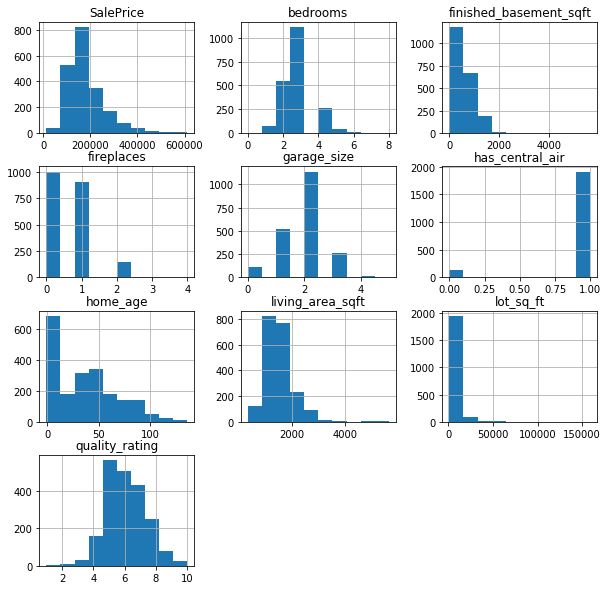

In [11]:
train[good_cols].hist(figsize=(10,10));

Checking feature & target correlations.

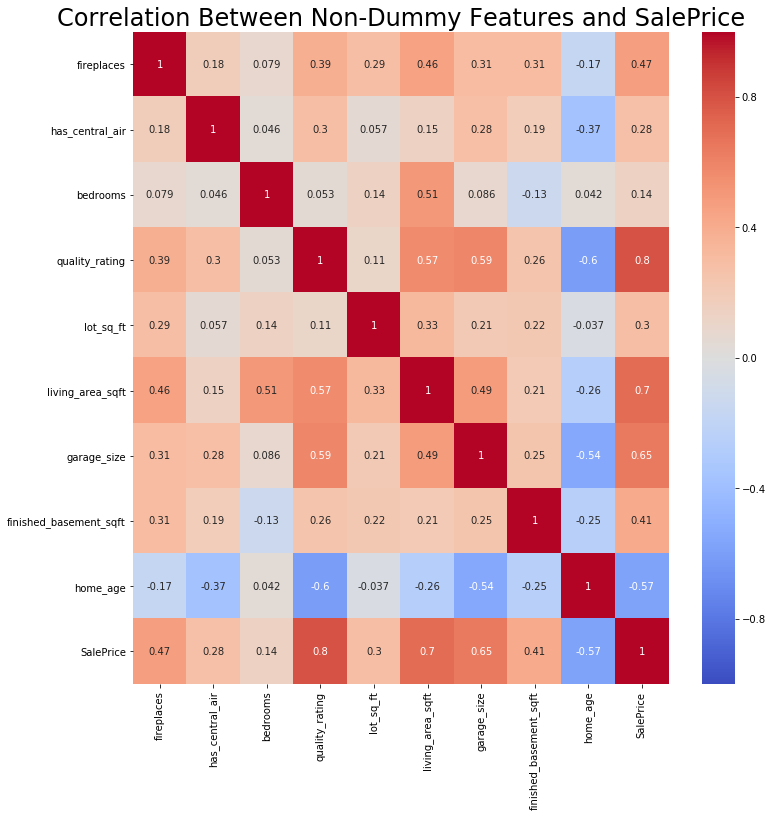

In [12]:
plt.figure(figsize=(12, 12))
sns.heatmap(train[good_cols].corr(),
           annot=True,
           cmap='coolwarm',
           vmin=-1)

plt.title("Correlation Between Non-Dummy Features and SalePrice", fontsize=24);

Home Age has the highest negative correlation on SalePrice and is even and Quality Rating has the highest positive correlation.

In [13]:
features = [col for col in good_cols if col != 'SalePrice']
features

['fireplaces',
 'has_central_air',
 'bedrooms',
 'quality_rating',
 'lot_sq_ft',
 'living_area_sqft',
 'garage_size',
 'finished_basement_sqft',
 'home_age']

Set features and target

In [14]:
X = train[features]
y = train['SalePrice']

In [15]:
X.head()

,fireplaces,has_central_air,bedrooms,quality_rating,lot_sq_ft,living_area_sqft,garage_size,finished_basement_sqft,home_age
0,0,1,3,6,13517,1479,2.0,533.0,34
1,1,1,4,7,11492,2122,2.0,637.0,13
2,0,1,3,5,7922,1057,1.0,731.0,57
3,0,1,3,5,9802,1444,2.0,0.0,4
4,0,1,3,6,14235,1445,2.0,0.0,110


In [16]:
y.head()

0    130500
1    220000
2    109000
3    174000
4    138500
Name: SalePrice, dtype: int64

Identify baseline prediction.

In [17]:
y.mean()

181469.70160897123

In [18]:
train['SalePrice'].dtype

dtype('int64')

Instantiate 

In [19]:
poly = PolynomialFeatures(include_bias=False)

Fit transform X

In [20]:
X_poly = poly.fit_transform(X)
X_poly.shape

(2051, 54)

Get poly feature names

In [21]:
poly_feat = poly.get_feature_names(features)

Create a new DataFrame

In [22]:
poly_df = pd.DataFrame(X_poly, columns=poly_feat)
poly_df = poly_df.set_index(train.index)
poly_df.head()

,fireplaces,has_central_air,bedrooms,quality_rating,lot_sq_ft,living_area_sqft,garage_size,finished_basement_sqft,home_age,fireplaces^2,...,living_area_sqft^2,living_area_sqft garage_size,living_area_sqft finished_basement_sqft,living_area_sqft home_age,garage_size^2,garage_size finished_basement_sqft,garage_size home_age,finished_basement_sqft^2,finished_basement_sqft home_age,home_age^2
0,0.0,1.0,3.0,6.0,13517.0,1479.0,2.0,533.0,34.0,0.0,...,2187441.0,2958.0,788307.0,50286.0,4.0,1066.0,68.0,284089.0,18122.0,1156.0
1,1.0,1.0,4.0,7.0,11492.0,2122.0,2.0,637.0,13.0,1.0,...,4502884.0,4244.0,1351714.0,27586.0,4.0,1274.0,26.0,405769.0,8281.0,169.0
2,0.0,1.0,3.0,5.0,7922.0,1057.0,1.0,731.0,57.0,0.0,...,1117249.0,1057.0,772667.0,60249.0,1.0,731.0,57.0,534361.0,41667.0,3249.0
3,0.0,1.0,3.0,5.0,9802.0,1444.0,2.0,0.0,4.0,0.0,...,2085136.0,2888.0,0.0,5776.0,4.0,0.0,8.0,0.0,0.0,16.0
4,0.0,1.0,3.0,6.0,14235.0,1445.0,2.0,0.0,110.0,0.0,...,2088025.0,2890.0,0.0,158950.0,4.0,0.0,220.0,0.0,0.0,12100.0


In [23]:
train['SalePrice'] = train['SalePrice'].astype(float)

Join `y` onto the new `poly_df` 

In [24]:
poly_df = poly_df.join(train['SalePrice'])

In [25]:
poly_df.isnull().sum().sort_values(ascending=False).head()

SalePrice                                 0
fireplaces lot_sq_ft                      0
has_central_air finished_basement_sqft    0
has_central_air garage_size               0
has_central_air living_area_sqft          0
dtype: int64

In [26]:
poly_df.head()

,fireplaces,has_central_air,bedrooms,quality_rating,lot_sq_ft,living_area_sqft,garage_size,finished_basement_sqft,home_age,fireplaces^2,...,living_area_sqft garage_size,living_area_sqft finished_basement_sqft,living_area_sqft home_age,garage_size^2,garage_size finished_basement_sqft,garage_size home_age,finished_basement_sqft^2,finished_basement_sqft home_age,home_age^2,SalePrice
0,0.0,1.0,3.0,6.0,13517.0,1479.0,2.0,533.0,34.0,0.0,...,2958.0,788307.0,50286.0,4.0,1066.0,68.0,284089.0,18122.0,1156.0,130500.0
1,1.0,1.0,4.0,7.0,11492.0,2122.0,2.0,637.0,13.0,1.0,...,4244.0,1351714.0,27586.0,4.0,1274.0,26.0,405769.0,8281.0,169.0,220000.0
2,0.0,1.0,3.0,5.0,7922.0,1057.0,1.0,731.0,57.0,0.0,...,1057.0,772667.0,60249.0,1.0,731.0,57.0,534361.0,41667.0,3249.0,109000.0
3,0.0,1.0,3.0,5.0,9802.0,1444.0,2.0,0.0,4.0,0.0,...,2888.0,0.0,5776.0,4.0,0.0,8.0,0.0,0.0,16.0,174000.0
4,0.0,1.0,3.0,6.0,14235.0,1445.0,2.0,0.0,110.0,0.0,...,2890.0,0.0,158950.0,4.0,0.0,220.0,0.0,0.0,12100.0,138500.0


Check new correlations.

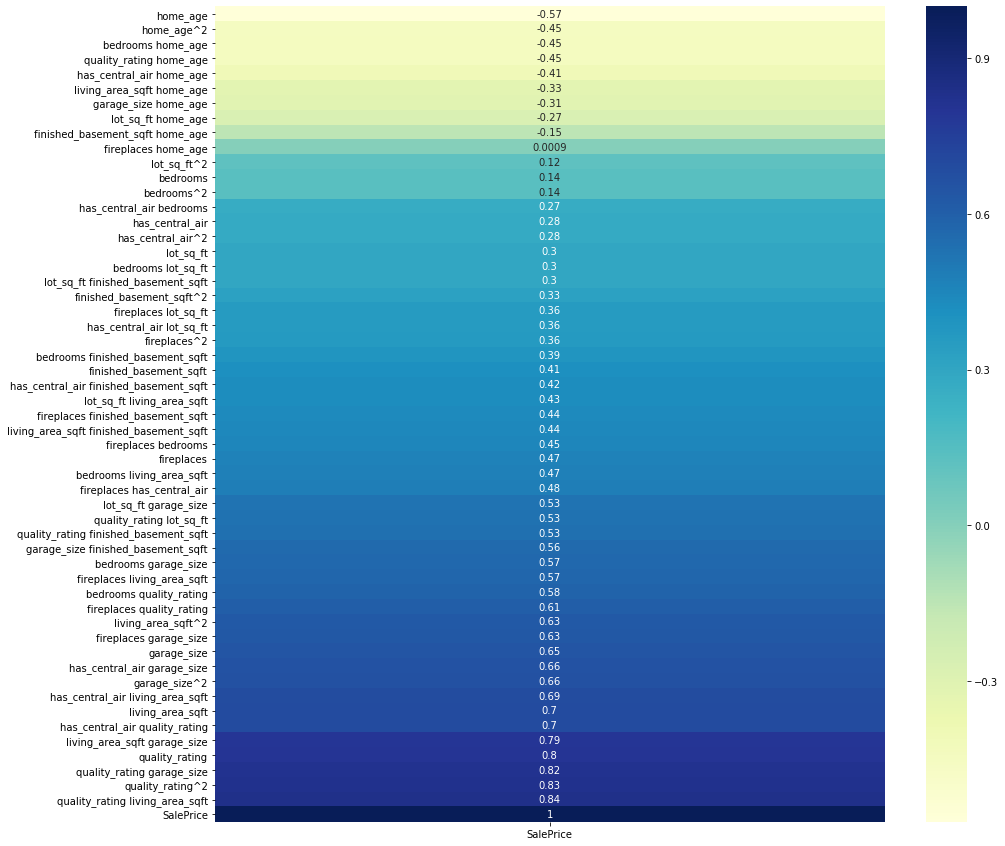

In [27]:
plt.figure(figsize=(15, 15))
sns.heatmap(poly_df.corr()[['SalePrice']].sort_values('SalePrice'), annot=True, cmap='YlGnBu')

Set new `X` for the polynomial features.

In [28]:
X = poly_df[poly_feat]

Train Test Split

In [29]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, random_state=23)

Now we need to scale the data so that all the different units are comparable. 
___

Instantiate Standard Scaler

In [30]:
ss = StandardScaler()

Fit & transform training data only.  Tranform holdout data.

In [31]:
X_train_sc = ss.fit_transform(X_train)
X_holdout_sc = ss.transform(X_holdout)

In [32]:
X_train.head()

,fireplaces,has_central_air,bedrooms,quality_rating,lot_sq_ft,living_area_sqft,garage_size,finished_basement_sqft,home_age,fireplaces^2,...,living_area_sqft^2,living_area_sqft garage_size,living_area_sqft finished_basement_sqft,living_area_sqft home_age,garage_size^2,garage_size finished_basement_sqft,garage_size home_age,finished_basement_sqft^2,finished_basement_sqft home_age,home_age^2
1247,0.0,1.0,3.0,3.0,10410.0,1214.0,3.0,0.0,91.0,0.0,...,1473796.0,3642.0,0.0,110474.0,9.0,0.0,273.0,0.0,0.0,8281.0
1467,0.0,1.0,3.0,6.0,11660.0,1326.0,2.0,0.0,0.0,0.0,...,1758276.0,2652.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
493,1.0,1.0,3.0,6.0,5707.0,1242.0,1.0,0.0,74.0,1.0,...,1542564.0,1242.0,0.0,91908.0,1.0,0.0,74.0,0.0,0.0,5476.0
769,0.0,1.0,3.0,5.0,10172.0,874.0,1.0,441.0,38.0,0.0,...,763876.0,874.0,385434.0,33212.0,1.0,441.0,38.0,194481.0,16758.0,1444.0
541,1.0,1.0,1.0,9.0,4538.0,1310.0,2.0,1004.0,7.0,1.0,...,1716100.0,2620.0,1315240.0,9170.0,4.0,2008.0,14.0,1008016.0,7028.0,49.0


Now I will run Cross Val Score on 3 different models to see which one performs best.

Instantiate Linear Regression.

In [33]:
lr = LinearRegression()

In [34]:
cross_val_score(lr, X_train_sc, y_train, cv=5).mean()


0.6669535841350909

In [35]:
# lr.fit(X_train_sc, y_train)

In [36]:
# lr.predict(X_train_sc)

In [37]:
# lr.score(X_train_sc, y_train)

In [38]:
# lr.score(X_holdout_sc, y_holdout)

Instantiate Ridge.

In [39]:
ridge = RidgeCV()

In [40]:
cross_val_score(ridge, X_train_sc, y_train, cv=5).mean()

0.6656865455748175

Instantiate LASSO.

In [41]:
lasso = LassoCV(cv=5)

In [42]:
cross_val_score(lasso, X_train_sc, y_train, cv=5).mean()

0.6387192361676579

Even though my LR model has the best cross val score, I am going to proceed with Lasso because I know I have way too many features right now. 

In [43]:
#find optimal alpha.
l_alphas=np.logspace(-3, 1, 100)

lasso = LassoCV(alphas=l_alphas, cv=5)

lasso = lasso.fit(X_train_sc, y_train)

/Users/rachelkoenig/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rachelkoenig/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rachelkoenig/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/rachelkoenig/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceW

In [44]:
lasso.alpha_

0.001

In [45]:
y_pred_train_lasso = lasso.predict(X_train_sc)
y_pred_train_lasso 

array([108922.03248014, 170177.51637316, 119556.37142346, ...,
       118039.97044192, 196914.47901971, 252921.16734233])

In [46]:
y_pred_test_lasso = lasso.predict(X_holdout_sc)

In [47]:
lasso.score(X_train_sc, y_train)

0.8918994438363689

In [48]:
lasso.score(X_holdout_sc, y_holdout)

0.8897151383494206

This R2 score on my training set tells me that 89% of the variability in the SalePrice is explained by the lasso model compared to the baseline prediction.  The fact that the R2 scores are nearly the same and both close to 1.0 tells me that the model has low variance and low bias.

In [49]:
lasso.coef_

array([ -2968.39497896,  11535.4170316 ,   1462.15769657, -17634.12768272,
        18215.63657389,   6068.78853599, -16914.01379787,  -2666.92683794,
       -23898.08362555,  -7216.89523788,   1255.16142413, -19908.32389294,
          993.48691874,   7301.51156895,  39232.96579384,  -8499.10767689,
         1831.26268227,   5925.99319996,  -3407.02313987,  -2562.18599841,
       -23486.26419412,  -6373.23955833,   8938.64111584,  -2434.84646698,
         9768.46875283,  12930.51658057, -16054.38685103, -13814.64261996,
        19735.98768539,  33756.03441383,  -3129.42748456,   8230.42358479,
         8278.94005781,  29031.07062754,  13867.93052457,  43101.29043464,
        29876.18876987,  28218.22425614,  -3702.41050044,  -6734.36142282,
       -45899.01680131,  11309.67630132,  -5240.12911021, -10179.08812467,
       -22274.47407904,   4509.63862085, -44284.65294053, -15400.74794289,
         1441.16741921,   -605.40421317,    534.560203  ,   7585.64776579,
         -763.8646907 ,  

In [50]:
residuals_lasso = y_holdout - y_pred_test_lasso

residuals_lasso.head()

# Xholdout[residuals]

864      6514.392113
317     -2644.149577
152    -11319.679227
28      23157.436746
1027    -6654.276417
Name: SalePrice, dtype: float64

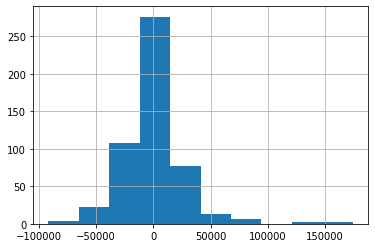

In [51]:
residuals_lasso.hist()

Residuals have a fairly normal distribution which is one of the rules of MLR so that's good.

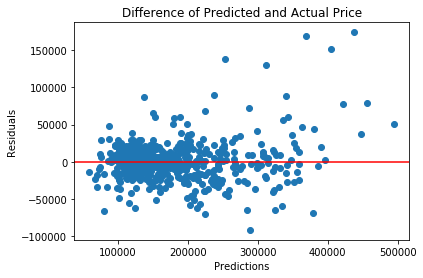

In [52]:
plt.scatter(y_pred_test_lasso, residuals_lasso)
plt.title("Difference of Predicted and Actual Price")
plt.xlabel("Predictions")
plt.ylabel("Residuals")

plt.axhline(y=0, color='r', linestyle='-');

In [53]:
rss_lasso = (residuals_lasso**2).sum()

lasso_RMSE = np.sqrt(rss_lasso / len(y_pred_test_lasso))
lasso_RMSE

28143.485123378763

Since my LASSO model didn't actually drive down any of my coefficients to 0, I will try Ridge now. 

In [54]:
ridge.fit(X_train_sc, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [55]:
ridge.score(X_train_sc, y_train)

0.8885043327660636

In [56]:
ridge.score(X_holdout_sc, y_holdout)

0.8941638972059281

In [57]:
y_pred_ridge = ridge.predict(X_holdout_sc)

In [58]:
residuals_ridge = y_holdout - y_pred_ridge

residuals_ridge.head()

864      3578.891466
317       796.699842
152    -18837.109270
28      16915.498445
1027    -4805.408846
Name: SalePrice, dtype: float64

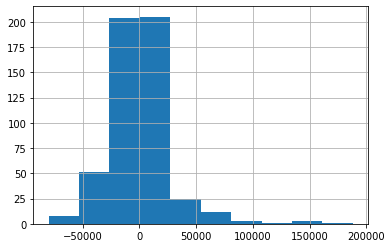

In [59]:
residuals_ridge.hist()

Ridge residuals have a good normal distribution however there a few outliers skewing it to the right.

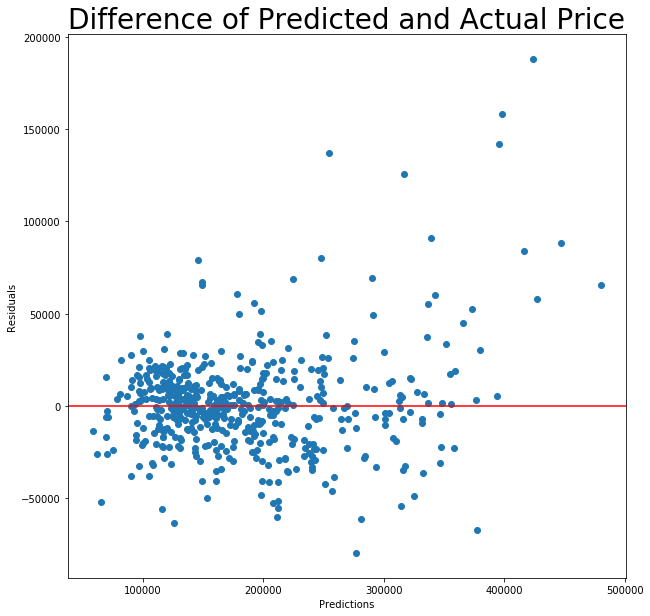

In [60]:
plt.figure(figsize=(10, 10))
plt.scatter(y_pred_ridge, residuals_ridge)
plt.title("Difference of Predicted and Actual Price", fontsize=28)
plt.xlabel("Predictions")
plt.ylabel("Residuals")

plt.axhline(y=0, color='r', linestyle='-');

There are a few outliers in the top right corner.  This tells me that the model is having a harder time predicting the price of some of the more expensive homes.  Overall, the errors are somewhat linear and normally distributed.

In [61]:
rss_ridge = (residuals_ridge**2).sum()

len(y_pred_ridge)

ridge_RMSE = np.sqrt(rss_ridge / len(y_pred_ridge))
ridge_RMSE

27570.00502486239

I didn't find any optimal alpha for the ridge model on the first try so since there is still room to improve, I will try that now. 

In [62]:
r_alphas = np.logspace(0, 5, 100)
# Generates 100 values equally between 0 and 5,
# then converts them to alphas between 10^0 and 10^5.

# Cross-validate over our list of ridge alphas.
ridge_model = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)

# Fit model using best ridge alpha!
ridge_model = ridge_model.fit(X_train_sc, y_train)

/Users/rachelkoenig/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [63]:
ridge_model.alpha_

1353.0477745798062

In [64]:
ridge_model.score(X_train_sc, y_train)

0.820047857223856

In [65]:
ridge_model.score(X_holdout_sc, y_holdout)

0.8361574854722718

I got a worse R2 score after finding the "optimal ridge alpha" so I'll keep the automatically generated one instead.

In [66]:
test.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


In [67]:
rename_cols(test)

In [68]:
for col in train:
    if type(train[col])== 'int64' or 'float64':
        train[col] = train[col].fillna(value=0)
    else:
        train[col] = train[col].fillna(value='None')
        

In [69]:
EDA(test)

In [70]:
X_test = test[features]
X_test.head()

,fireplaces,has_central_air,bedrooms,quality_rating,lot_sq_ft,living_area_sqft,garage_size,finished_basement_sqft,home_age
0,0,0,4,6,9142,1928,1.0,0.0,96
1,0,1,6,5,9662,1967,2.0,0.0,29
2,1,1,3,7,17104,1496,2.0,554.0,0
3,0,1,2,5,8520,968,2.0,0.0,84
4,2,1,3,6,9500,1394,2.0,609.0,46


In [71]:
X_poly_test = poly.transform(X_test)

In [72]:
poly_df_test = pd.DataFrame(X_poly_test, columns=poly_feat)
poly_df_test = poly_df_test.set_index(test.index)

In [73]:
X_poly_test_sc = ss.transform(X_poly_test)

In [74]:
y_hat = lasso.predict(X_poly_test_sc)
y_hat_ridge = ridge.predict(X_poly_test_sc)

In [75]:
poly_df_test.head()

,fireplaces,has_central_air,bedrooms,quality_rating,lot_sq_ft,living_area_sqft,garage_size,finished_basement_sqft,home_age,fireplaces^2,...,living_area_sqft^2,living_area_sqft garage_size,living_area_sqft finished_basement_sqft,living_area_sqft home_age,garage_size^2,garage_size finished_basement_sqft,garage_size home_age,finished_basement_sqft^2,finished_basement_sqft home_age,home_age^2
0,0.0,0.0,4.0,6.0,9142.0,1928.0,1.0,0.0,96.0,0.0,...,3717184.0,1928.0,0.0,185088.0,1.0,0.0,96.0,0.0,0.0,9216.0
1,0.0,1.0,6.0,5.0,9662.0,1967.0,2.0,0.0,29.0,0.0,...,3869089.0,3934.0,0.0,57043.0,4.0,0.0,58.0,0.0,0.0,841.0
2,1.0,1.0,3.0,7.0,17104.0,1496.0,2.0,554.0,0.0,1.0,...,2238016.0,2992.0,828784.0,0.0,4.0,1108.0,0.0,306916.0,0.0,0.0
3,0.0,1.0,2.0,5.0,8520.0,968.0,2.0,0.0,84.0,0.0,...,937024.0,1936.0,0.0,81312.0,4.0,0.0,168.0,0.0,0.0,7056.0
4,2.0,1.0,3.0,6.0,9500.0,1394.0,2.0,609.0,46.0,4.0,...,1943236.0,2788.0,848946.0,64124.0,4.0,1218.0,92.0,370881.0,28014.0,2116.0


In [76]:
pf_submission_df = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': y_hat   
})
pf_submission_df.head()

,Id,SalePrice
0,2658,127176.797378
1,2718,144930.117356
2,2414,235673.290665
3,1989,105434.887475
4,625,155212.931430


In [77]:
pf_submission_df.to_csv('data/submission5.csv', index=False)

In [78]:
pf_submission2_df = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': y_hat_ridge   
})
pf_submission2_df.head()

,Id,SalePrice
0,2658,126856.075484
1,2718,147200.521992
2,2414,238027.696719
3,1989,102189.429632
4,625,165151.510172


In [79]:
pf_submission2_df.to_csv('data/submission7.csv', index=False)

Add the residuals the my holdout

In [80]:
X_holdout['residuals'] = pd.Series.to_frame(residuals_ridge)
X_holdout.shape


/Users/rachelkoenig/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(513, 55)

In [81]:
X_holdout[X_holdout['residuals'] >= 140000]

,fireplaces,has_central_air,bedrooms,quality_rating,lot_sq_ft,living_area_sqft,garage_size,finished_basement_sqft,home_age,fireplaces^2,...,living_area_sqft garage_size,living_area_sqft finished_basement_sqft,living_area_sqft home_age,garage_size^2,garage_size finished_basement_sqft,garage_size home_age,finished_basement_sqft^2,finished_basement_sqft home_age,home_age^2,residuals
151,1.0,1.0,4.0,9.0,16056.0,2868.0,3.0,240.0,1.0,1.0,...,8604.0,688320.0,2868.0,9.0,720.0,3.0,57600.0,240.0,1.0,158379.960738
1671,2.0,1.0,2.0,9.0,12919.0,2364.0,3.0,2188.0,1.0,4.0,...,7092.0,5172432.0,2364.0,9.0,6564.0,3.0,4787344.0,2188.0,1.0,188196.868870
823,1.0,1.0,4.0,8.0,53504.0,3279.0,3.0,1416.0,7.0,1.0,...,9837.0,4643064.0,22953.0,9.0,4248.0,21.0,2005056.0,9912.0,49.0,142286.539069


In [82]:
train['SalePrice'].sort_values(ascending=False).head(15)

1671    611657.0
1964    591587.0
1692    584500.0
1796    582933.0
151     556581.0
1164    555000.0
623     552000.0
138     545224.0
823     538000.0
1592    535000.0
81      501837.0
800     500067.0
1227    500000.0
1700    485000.0
1035    475000.0
Name: SalePrice, dtype: float64

In [83]:
train[train['SalePrice'] >= 500000].describe()

,Id,parcel_id,ms_subclass,lot_frontage,lot_sq_ft,paved_street,quality_rating,condition_rating,year_built,year_renovation,...,screen_porch_sqft,pool_size,misc_value,month_sold,year_sold,SalePrice,baths,finished_basement_sqft,home_age,newly_renovated
count,13.000000,1.300000e+01,13.000000,13.000000,13.000000,13.0,13.000000,13.0,13.000000,13.000000,...,13.000000,13.0,13.0,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,1121.538462,5.277291e+08,38.461538,83.384615,21450.692308,1.0,9.307692,5.0,2005.076923,2005.692308,...,84.923077,0.0,0.0,5.461538,2008.000000,550337.384615,3.653846,1326.846154,2.923077,0.076923
std,1011.601586,5.005838e+05,20.754981,24.312337,13970.650554,0.0,0.630425,0.0,4.112208,4.049375,...,116.866349,0.0,0.0,2.366974,1.683251,36034.145535,0.515777,803.027900,3.946761,0.277350
min,16.000000,5.272100e+08,20.000000,47.000000,12919.000000,1.0,8.000000,5.0,1993.000000,1994.000000,...,0.000000,0.0,0.0,1.000000,2006.000000,500000.000000,3.000000,0.000000,0.000000,0.000000
25%,367.000000,5.272141e+08,20.000000,60.000000,14836.000000,1.0,9.000000,5.0,2004.000000,2005.000000,...,0.000000,0.0,0.0,4.000000,2006.000000,535000.000000,3.500000,1101.000000,1.000000,0.000000
50%,457.000000,5.281060e+08,20.000000,85.000000,16056.000000,1.0,9.000000,5.0,2006.000000,2006.000000,...,0.000000,0.0,0.0,6.000000,2009.000000,552000.000000,3.500000,1416.000000,1.000000,0.000000
75%,2331.000000,5.281501e+08,60.000000,105.000000,17423.000000,1.0,10.000000,5.0,2008.000000,2008.000000,...,192.000000,0.0,0.0,7.000000,2009.000000,582933.000000,3.500000,1904.000000,5.000000,0.000000
max,2451.000000,5.283600e+08,60.000000,114.000000,53504.000000,1.0,10.000000,5.0,2009.000000,2010.000000,...,322.000000,0.0,0.0,9.000000,2010.000000,611657.000000,4.500000,2306.000000,13.000000,1.000000


In [84]:
train.loc[train['SalePrice'] >= 500000, ['neighborhood']]

,neighborhood
81,StoneBr
138,StoneBr
151,StoneBr
623,NridgHt
800,NridgHt
823,StoneBr
1164,NridgHt
1227,NridgHt
1592,StoneBr
1671,NridgHt


In [85]:
train['neighborhood'].value_counts()

NAmes      310
CollgCr    180
OldTown    163
Edwards    143
Somerst    130
NridgHt    122
Gilbert    116
Sawyer     111
SawyerW     87
NWAmes      87
Mitchel     82
BrkSide     76
Crawfor     71
IDOTRR      69
NoRidge     48
Timber      48
StoneBr     38
SWISU       32
ClearCr     27
MeadowV     24
Blmngtn     22
BrDale      19
NPkVill     17
Veenker     17
Blueste      6
Greens       3
GrnHill      2
Landmrk      1
Name: neighborhood, dtype: int64

I found a correlation between high priced homes and neighborhoods, however, since this is a categorical feature, I cannot easitly add it on to my scaled polynomial features. 

In [86]:
train.loc[train['SalePrice'] >= 500000, ['pool_quality']]

,pool_quality
81,0
138,0
151,0
623,0
800,0
823,0
1164,0
1227,0
1592,0
1671,0


In [87]:
train.loc[train['SalePrice'] >= 500000, ['misc_value']]

,misc_value
81,0
138,0
151,0
623,0
800,0
823,0
1164,0
1227,0
1592,0
1671,0


I check to see if the numerical features, Pool Quality and/or Misc Value have any correlation to the high priced homes and am very surprised to see none of them have either. 

### Executive Summary

I am confident with my model.  It has a high accuracy score that is similar for the both the train and test data.  Therefore, I have low variance and low bias.  There are a few outliers that tell me the model is not scoring as well on a few high price homes so there is still room to improve.  With more time and resources I would dive deeper into the categorical feature, neighboorhoods because I found that houses over $500,000 were all in only two places.  